In [0]:
import numpy as np
from collections import defaultdict
import re

In [0]:
file_learning = 'imat2009_learning.txt'

with open(file_learning) as f:
    train_data = f.readlines()

In [3]:
train_data[0]

'1 1:0.000023 7:0.704953 8:0.550315 9:0.032294 11:0.712631 14:0.015686 15:0.137255 16:0.302576 17:1.000000 18:0.996078 22:1.000000 23:1.000000 24:1.000000 27:0.700000 28:0.587629 29:0.999881 30:0.032294 34:0.000023 36:0.431373 37:0.002247 38:0.054902 41:1.000000 46:0.002247 50:0.032294 51:0.325613 52:0.056641 53:0.820677 54:0.388235 55:0.450980 56:0.312547 57:0.004672 59:1.000000 61:0.000023 65:1.000000 68:0.712195 69:0.001400 70:1.000000 71:0.001013 73:0.709459 74:0.560784 76:0.142857 77:0.360800 78:1.000000 79:1.000000 80:1.000000 82:0.000023 83:1.000000 85:0.996078 86:0.070588 87:1.000000 88:0.999797 92:1.000000 93:0.714286 95:0.039216 97:0.000023 98:0.356490 99:0.165041 102:1.000000 103:1.000000 104:1.000000 105:0.486275 108:0.152941 120:0.996078 121:0.676507 122:0.032294 126:0.712980 128:0.121569 129:0.609261 132:1.000000 134:0.109804 135:0.030535 140:0.002247 142:0.698039 144:0.248111 145:0.356490 146:1.000000 147:0.498039 148:0.125490 150:0.704953 151:1.000000 152:0.098039 154:0

In [0]:
labels = [] 
queries_lines_info = defaultdict(list) 

data = np.zeros((len(train_data), 245), dtype=np.float32)

In [0]:
for idx, line in enumerate(train_data):
  line = line.split()
  labels.append(float(line[0]))
  q_id = line[-1].strip('\n')
  queries_lines_info[q_id].append(idx)
  features = line[1:-2]
  for feat in features:
    feat = feat.split(':')
    data[idx][int(feat[0])-1] = float(feat[1])

In [0]:
assert data.shape == (len(train_data), 245)
assert len(queries_lines_info.keys()) == 9124
assert len(labels) == len(train_data)

In [0]:
from sklearn.model_selection import train_test_split

train_queries_ids, test_queries_ids = train_test_split(list(queries_lines_info.keys()), test_size=0.3, random_state=42)

In [0]:
# check
assert len(train_queries_ids) / (len(train_queries_ids) + len(test_queries_ids)) == 0.6999123191582639

In [0]:
train_queries_lines_info = []
for q_id in train_queries_ids:
    train_queries_lines_info += queries_lines_info[q_id]

In [0]:
test_queries_lines_info = []
for q_id in test_queries_ids:
    test_queries_lines_info += queries_lines_info[q_id]

In [0]:
labels = np.array(labels)
train_queries_lines_info = np.array(train_queries_lines_info)
test_queries_lines_info = np.array(test_queries_lines_info)

In [0]:
X_train, X_test = data[train_queries_lines_info], data[test_queries_lines_info]
Y_train, Y_test = labels[train_queries_lines_info], labels[test_queries_lines_info] 

In [0]:
assert X_train.shape == (68418, 245) 
assert len(Y_train) == 68418

In [0]:
import metrics

def get_nDCG_score(queries, queries_lines_info, test_queries_lines_info, labels_true, labels_predicted):
    nDCG_scores = [] # nDCG по каждому запросу
    
    for query in queries:
        
        query_lines = queries_lines_info[query]
        query_lines_in_testdata = [np.where(test_queries_lines_info==line)[0][0] for line in query_lines]
        
        query_labels_true = labels[query_lines]
        query_labels_pred = labels_predicted[query_lines_in_testdata]
        
        nDCG = metrics.ndcg_score(query_labels_true, query_labels_pred, k=10)
        nDCG_scores.append(nDCG)
        
    nDCG_Queries = np.sum(nDCG_scores) / len(queries) # усредняем по всем запросам
    return nDCG_Queries

In [0]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, Y_train)

lin_reg_y_pred = lin_reg.predict(X_test)

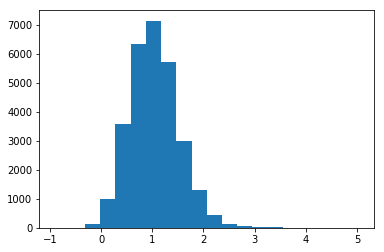

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

h = plt.hist(lin_reg_y_pred, bins=20)

In [17]:
score_lin_reg = get_nDCG_score(
    queries = test_queries_ids, 
    queries_lines_info = queries_lines_info, 
    test_queries_lines_info = test_queries_lines_info, 
    labels_true = Y_test, 
    labels_predicted = lin_reg_y_pred
)
 
score_lin_reg

0.8282199816480288

Классификация

In [18]:
## Классификация не работает на данных типа continuous

from sklearn.svm import LinearSVC

svc = LinearSVC()
svc.fit(X_train, Y_train)

svc_y_pred = svc.predict(X_test)

ValueError: ignored

Ранжируем с RandomForestRegressor

In [0]:
from sklearn.ensemble import RandomForestRegressor

In [20]:

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_train, Y_train)


labels_predicted_rf = rf.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [21]:
score_rf = get_nDCG_score(
    queries = test_queries_ids, 
    queries_lines_info = queries_lines_info, 
    test_queries_lines_info = test_queries_lines_info, 
    labels_true = Y_test, 
    labels_predicted = labels_predicted_rf
)
 
score_rf

0.8199034545946894

Ранжируем с XGBoost

In [0]:
import xgboost


Ранжируем с LightGBM

In [0]:
import lightgbm

In [0]:
train = lightgbm.Dataset(X_train, label=Y_train)
test = lightgbm.Dataset(X_test, label=Y_test)
